<img src="https://upload.wikimedia.org/wikipedia/fr/b/bf/Universit%C3%A9_Laval_logo_et_texte.svg" width=200 align="right"><br>
<b> Projet de conception en génie physique GPH-3110 </b><br>
<b> Département de physique, de génie physique et d'optique </b><br>
<b> Hiver 2023 </b><br>
<b> Université Laval </b><br>

<center><h1>Thermistor voltage - temperature simulation</h2></center>

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = "svg"

import numpy as np
from pandas import read_excel
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
plt.rcParams.update(
    {
        "lines.linewidth": 1.5,
        "axes.labelsize": "x-large",
        "axes.labelpad": 10,
        "axes.grid": True,
        "axes.grid.which": "both",
        "grid.linestyle": ":",
        "grid.color": "k",
        "grid.alpha": 0.5,
        "xtick.minor.visible": True,
        "xtick.direction": "in",
        "xtick.major.size": 10,
        "xtick.major.width": 1,
        "xtick.minor.size": 5,
        "xtick.minor.width": 0.5,
        "ytick.minor.visible": True,
        "ytick.direction": "in",
        "ytick.major.size": 10,
        "ytick.major.width": 1,
        "ytick.minor.size": 5,
        "ytick.minor.width": 0.5,
    }
)

## Steinhart-Hart equation

The Steinhart-Hart equation is a model of the resistance $R$ of a semiconductor at different temperatures $T$. The equation is
\begin{align}
    \frac{1}{T} &= A+B\ln{\left(\frac{R}{R_{25}}\right)}+C\ln\left(\frac{R}{R_{25}}\right)^2+D\ln{\left(\frac{R}{R_{25}}\right)}^3 \ , \\[0.25cm]
    R(T) &= R_{25}e^{A+\frac{B}{T}+\frac{C}{T^2}+\frac{D}{T^3}}
\end{align}

### Find $A$, $B$, $C$ and $D$ with curve fit

#### Extract thermistor data from datasheet

In [3]:
data = read_excel("NTCLE350E4103FHB0.xlsx", header=1)
data = data.to_numpy()

# Thermistor nominal resistance (25°C)
R25 = 10e3

T = data[:, 0]
R = data[:, 1]
ln = data[:, 2]
dR = data[:, 3]
alpha = data[:, 4]
dT = data[:, 5]
Rmin = data[:, 6]
Rmax = data[:, 7]

# Steinhart-Hart coefficients according to documentation
A1 = 0.00335401643468053
B1 = 0.000256523550896126
C1 = 2.60597012072052e-06
D1 = 6.32926126487455e-08

# Inverse Steinhart-Hart coefficients according to documentation
A = -14.65719769
B = 4798.842
C = -115334
D = -3730535

#### Define Steinhart-Hart equations

In [4]:
def steinhart_hart(res: np.ndarray | float) -> np.ndarray | float:
    """Calculate thermistor temperature with Steinhart-Hart equation.

    Parameters:
    -----------
        res : float
            Thermistor resistance.

    Returns:
    --------
        temp : float
            Thermistor temperature in kelvin.

    """
    global R, T, A1, B1, C1, D1, R25

    # Check if input value is not already in datasheet
    # if np.any(np.in1d(res, R)) is True:
    #     idx = np.where(R==res)[0]
    #     return T[idx]

    ln = res/R25
    temp = A1 + B1*np.log(ln) + C1*np.log(ln)**2 + D1*np.log(ln)**3
    temp = temp**-1 - 273.15
    return temp


def steinhart_curvefit(
    R: float | np.ndarray,
    A: float,
    B: float,
    C: float,
    D: float,
) -> float | np.ndarray:
    global R25

    ln = R/R25
    temp = A + B*np.log(ln) + C*np.log(ln)**2 + D*np.log(ln)**3
    temp = temp**-1 - 273.15
    return temp


def inv_steinhart(t: np.ndarray| float) -> np.ndarray | float:
    """Calculate thermistor resistance with Steinhart-Hart equation.

    Args:
        temp : np.ndarray or float
            Thermistor temperature in celsius.

    Returns:
        res : np.ndarray or float.
            Thermistor resistance in ohms.

    """
    global T, R, A, B, C, D, R25
    
    # Check if input value is not already in datasheet
    # if np.any(np.in1d(t, T)) is True:
    #     idx = np.where(T==t)[0]
    #     return R[idx]

    # Convert temperature to absolute
    temp = t + 273.15

    res = R25*np.exp(A + B/temp + C/temp**2 + D/temp**3)
    return res


def inv_steinhart_fit(t, A, B, C, D):
    global R25
    
    temp = t + 273.15
    res = R25*np.exp(A + B/temp + C/temp**2 + D/temp**3)
    return res


def tolerance(temp: float) -> float:
    """Calculate sensor resistance tolerance at given temperature.

    Parameter:
    ----------
        T : float
            Thermistor temperature in celsius.

    Returns:
    --------
        dR : float
            Sensor resistance tolerance in %.

    """
    # Convert input to absolute temperature
    temp += 273.15

    # B and R25 alue tolerance
    dR25 = 1
    dB = 0.5

    dR = dR25 + dB*np.abs(1/temp - 1/298.15)
    return dR


def tol(temp: float | np.ndarray) -> float | np.ndarray:
    global A, B, C, D, R25

    # Convert temperature to absolute
    temp += 273.15
    
    res = R25*np.exp(A + B/temp + C/temp**2 + D/temp**3)
    return res


def tolerance_fit(temp, A, B, C, D):
    global R25

    # Convert temperature to absolute
    temp += 273.15
    
    res = R25*np.exp(A + B/temp + C/temp**2 + D/temp**3)
    return res


def voltage(res, Vs=3.3):
    v = res*Vs / (res + 10e3)
    return v

In [5]:
# Exemple
print(steinhart_hart(11e3))
inv_steinhart(15)

22.840267096048024


15711.255223590735

#### Curve fit data

Provided coeffs: [3.35401643e-03 2.56523551e-04 2.60597012e-06 6.32926126e-08]
Fitted coeffs: [3.35397383e-03 2.56520083e-04 2.61151512e-06 6.37588512e-08]
Average coeffs: [3.35399513e-03 2.56521817e-04 2.60874262e-06 6.35257319e-08]
Coeffs precision: [1.06514106e-08 8.66942701e-10 1.38624996e-09 1.16559642e-10]


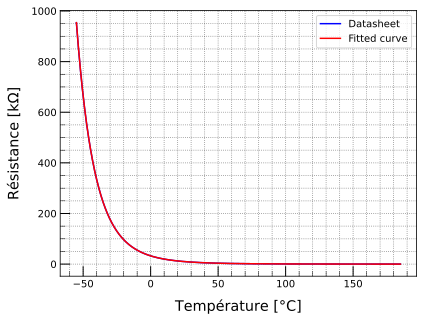

In [6]:
coeffs = np.array((A1, B1, C1, D1))
popt, _ = curve_fit(steinhart_curvefit, R, T, p0=coeffs)

# Keep average of the two sets
av = 0.5*(popt + coeffs)
precision = np.abs(0.5*(popt-av))

print(f"Provided coeffs: {coeffs}")
print(f"Fitted coeffs: {popt}")
print(f"Average coeffs: {av}")
print(f"Coeffs precision: {precision}")

plt.plot(T, R*1e-3, "b", label="Datasheet")
plt.plot(steinhart_curvefit(R, *popt), R*1e-3, "r", label="Fitted curve")
plt.ylabel("Résistance [k$\Omega$]")
plt.xlabel("Température [$\degree$C]")
plt.legend()
plt.show()

#### Plot fitted curve from 15&deg;C to 150&deg;C

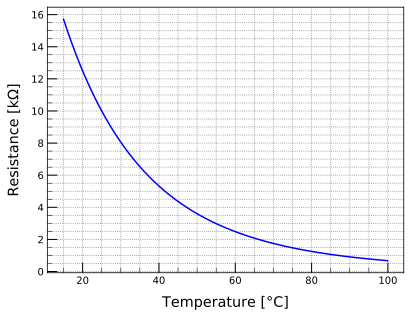

In [7]:
idx = np.where(T==15)[0].item()
idx2 = np.where(T==100)[0].item()

_temp = T[idx:idx2]
res = R[idx:idx2]
SH_params, _ = curve_fit(steinhart_curvefit, res, _temp, p0=coeffs, maxfev=10000)

plt.plot(_temp, res*1e-3, "b", label="Datasheet")
# plt.plot(steinhart_curvefit(res, *SH_params), res*1e-3, "r", label="Fitted resistance")

# Fit with the Steinhart-Hart coefficients provided in datasheet
# plt.plot(steinhart_hart(res), res*1e-3, "g", label="Given SH coeffs")

plt.ylabel("Resistance [k$\Omega$]")
plt.xlabel("Temperature [$\degree$C]")
# plt.legend()
plt.savefig("NTCLE350E4103FHB0.pdf", dpi=1000)
plt.show()

### Thermistor tolerance and resistance from 15&deg;C to 150&deg;C

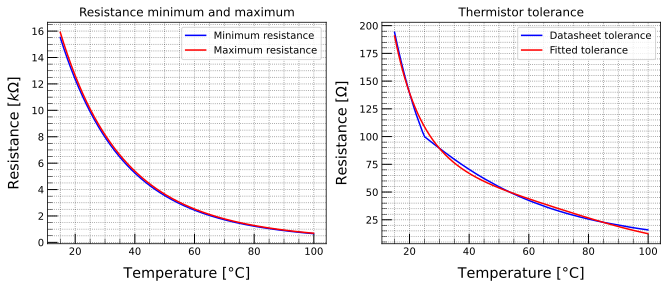

In [8]:
a = np.asarray((A, B, C, D))
R1 = Rmin[idx:idx2]
R2 = Rmax[idx:idx2]
T_params, _ = curve_fit(inv_steinhart_fit, _temp, res, p0=a)
_minR, _ = curve_fit(inv_steinhart_fit, _temp, R1, p0=a)
_maxR, _ = curve_fit(inv_steinhart_fit, _temp, R2, p0=a)
deltaR, _ = curve_fit(inv_steinhart_fit, _temp, 0.5*(R2-R1), p0=a, maxfev=10000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
ax1.plot(_temp, R1*1e-3, "b", label="Minimum resistance")
ax1.plot(_temp, R2*1e-3, "r", label="Maximum resistance")
ax1.set_title("Resistance minimum and maximum")
ax1.set_ylabel("Resistance [$k\Omega$]")
ax2.plot(_temp, 0.5*(R2-R1), "b", label="Datasheet tolerance")
ax2.plot(_temp, inv_steinhart_fit(_temp, *deltaR), "r", label="Fitted tolerance")
ax2.set_title("Thermistor tolerance")
ax2.set_ylabel("Resistance [$\Omega$]")
for ax in (ax1, ax2):
    ax.set_xlabel("Temperature [$\degree$C]")
    ax.legend()

plt.savefig("Tolerance.pdf", dpi=1000)

## Wheatstone bridge
<center><img src="https://upload.wikimedia.org/wikipedia/commons/9/93/Wheatstonebridge.svg" width=300></center>

The thermistor resistance $R_x$ is given by
\begin{gather}
    R_x = R + \Delta R \ , \tag{3}
\end{gather}

where $R$ is the nominal thermistor resistance at 25&deg;C and $\Delta R$ is the resistance change of the thermistor. From Kirchhoff's laws and the fact that $R_1=R_2=R_3=R$, we have
\begin{align}
    V_G &= B - D = V_s\left[\frac{R+\Delta R}{2R+\Delta R}-\frac{1}{2}\right] \ , \tag{4} \\[0.25cm]
    &= \frac{\Delta R}{4R+2\Delta R}V_s \ , \tag{5} \\[0.25cm]
    \Delta R &= -\frac{4RV_G}{2V_G-V_s} \ , \tag{6} \\[0.25cm]
\end{align}

where $V_s$ is the supply voltage. Considering that $B$ and $D$ are connected to a instrumentation amplifier, we know that the output voltage $V_{out}$ is given by
\begin{align}
    V_{out} &= V_{ref} + GV_G \ , \tag{7} \\[0.25cm]
    V_G &= \frac{V_{out} - V_{ref}}{G} \ , \tag{8} \\[0.25cm]
\end{align}

where $G$ is the amplifier gain. Finally,
\begin{gather}
    R_x = R+\Delta R = R\left(1 - \frac{4R\left(V_{out}-V_{ref}\right)}{2V_{out}-GV_s-2V_{ref}}\right) \ , \tag{9}
\end{gather}

where $V_{out}$ is the amplifier output voltage and $V_{ref}$ is the amplifier reference voltage.

In [9]:
def simulation(
    dV: float,
    G: float | int = 1,
    R: int = 10e3,
    Vs: float = 3.3,
) -> float:
    """Calculate thermistor temperature based on amplifier's output voltage.

    Parameters:
    -----------
        dV : float
            _description_
        G : float or int, optional
            Amplifier gain. Defaults to 1.
        R : int, optional
            Thermistor nominal resistance at 25°C. Defaults to 10 000.
        Vs : float, optional
            Weatstone bridge supply voltage in volts. Defaults to 3.3.

    Returns:
    --------
        T : float
            Thermistor temperature in °C.

    """
    Rx = R*(1 - (4*dV) / (2*dV - G*Vs))
    T = steinhart_curvefit(Rx, *SH_params)
    return T

#### Simulation results

In [10]:
# Try with experimental values
s = simulation(0.26892, G=1.494)
print(f"Temperature: {s:.3f}°C")

Temperature: 20.078°C


## Current calculation

In [11]:
def current(
    T: float,
    Vs: float = 3.3,
    n: int = 1,
    dR3: float = 0.1,
) -> float:
    """Calculate thermistors current consumption.

    Args:
        T : float
            Thermistor temperature in celsius
        Vs : float, optional
            Thermistors supply voltage. Defaults to 3.3V.
        n : int, optional
            Number of supplied thermistors per reading sequence. Defaults to 1.
        dR3 : float, optional
            R3 resistor tolerance in %. Defaults to 0.1%.

    Returns:
        I : float
            Total current consumption in amps.

    """
    R = inv_steinhart_fit(T, *T_params)
    I = n*(Vs / 2e4 + Vs / R)*1e3
    return I

In [12]:
I = current(15, 8)
print(f"Total thermistors current consumption: {I:.4f} mA")

Total thermistors current consumption: 0.9092 mA


## ADC resolution

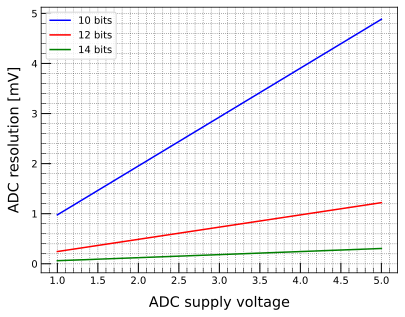

In [13]:
def ADC_supply(v, bits=12):
    resolution = v / 2**bits
    return resolution


vs = np.linspace(1, 5, 1000)
plt.plot(vs, ADC_supply(vs, 10)*1e3, "b", label="10 bits")
plt.plot(vs, ADC_supply(vs)*1e3, "r", label="12 bits")
plt.plot(vs, ADC_supply(vs, 14)*1e3, "g", label="14 bits")
plt.xlabel("ADC supply voltage")
plt.ylabel("ADC resolution [mV]")
plt.legend()

#### Analyse voltage value at given temperature

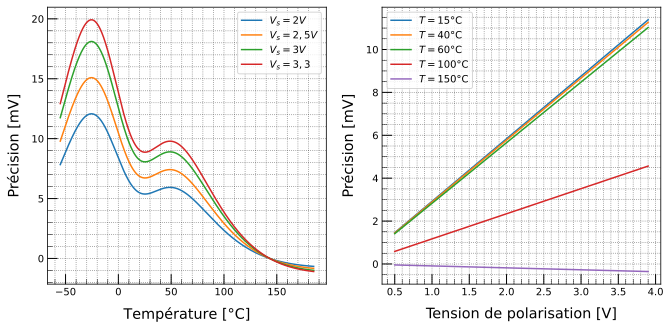

In [14]:
def voltage_sim(t, Vs=3.3):
    # Extract Rmin and Rmax at given temperature
    _Rmin = inv_steinhart_fit(t, *_minR)
    _Rmax = inv_steinhart_fit(t, *_maxR)
    _R = inv_steinhart_fit(t, *T_params)
    Rrange = _Rmax - _Rmin

    # Calculate voltage and voltage range
    Vmin = voltage(_Rmin, Vs)
    Vmax = voltage(_Rmax, Vs)
    V = voltage(_R, Vs)
    Vrange = Vmax - Vmin

    return _Rmin, _Rmax, Rrange, Vmin, Vmax, V, Vrange


Trange = np.arange(-55, 185, 0.1)
acc2 = 0.5*voltage_sim(Trange, 2)[-1]
acc25 = 0.5*voltage_sim(Trange, 2.5)[-1]
acc3 = 0.5*voltage_sim(Trange, 3)[-1]
acc33 = 0.5*voltage_sim(Trange)[-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
ax1.plot(Trange, acc2*1e3, label="$V_s=2 V$")
ax1.plot(Trange, acc25*1e3, label="$V_s=2,5 V$")
ax1.plot(Trange, acc3*1e3, label="$V_s=3 V$")
ax1.plot(Trange, acc33*1e3, label="$V_s=3,3$")
ax1.set_xlabel("Température [$\degree$C]")
ax1.set_ylabel("Précision [mV]")
ax1.legend()

Vbias = np.arange(0.5, 4, 0.1)
temp1 = (
    15,
    40,
    60,
    100,
    150,
)
dV = (
    0.5*voltage_sim(15, Vbias)[-1],
    0.5*voltage_sim(40, Vbias)[-1],
    0.5*voltage_sim(60, Vbias)[-1],
    0.5*voltage_sim(100, Vbias)[-1],
    0.5*voltage_sim(150, Vbias)[-1],
)
for x, y in enumerate(dV):
    ax2.plot(Vbias, y*1e3, label=f"$T={temp1[x]}$°C")

ax2.legend()
ax2.set_xlabel("Tension de polarisation [V]")
ax2.set_ylabel("Précision [mV]")
fig.savefig("Accuracy.pdf", dpi=1000)

In [15]:
_Rmin, _Rmax, Rrange, Vmin, Vmax, V, Vrange = voltage_sim(15, 3.4)
_Rmin2, _Rmax2, Rrange2, Vmin2, Vmax2, V2, Vrange2 = voltage_sim(100, 3.4)

print("Dataset #1:")
print("-----------")
print(f"Minimum resistance value: {_Rmin:.4f} Ω")
print(f"Maximum resistance value: {_Rmax:.4f} Ω")
print(f"Resistance value range: {Rrange:.4f} Ω")
print(f"Minimum voltage value: {Vmin:.4f} V")
print(f"Maximum voltage value: {Vmax:.4f} V")
print(f"Voltage value range: {Vrange*1e3:.4f} mV")
print(f"Voltage measurement: {V:.4f} V ± {0.5*Vrange*1e3:.4f} mV")
print()
print("Dataset #2:")
print("-----------")
print(f"Minimum resistance value: {_Rmin2:.4f} Ω")
print(f"Maximum resistance value: {_Rmax2:.4f} Ω")
print(f"Resistance value range: {Rrange2:.4f} Ω")
print(f"Minimum voltage value: {Vmin2:.4f} V")
print(f"Maximum voltage value: {Vmax2:.4f} V")
print(f"Voltage value range: {Vrange2*1e3:.4f} mV")
print(f"Voltage measurement: {V2:.4f} V ± {0.5*Vrange2*1e3:.4f} mV")

Dataset #1:
-----------
Minimum resistance value: 15518.2411 Ω
Maximum resistance value: 15904.2037 Ω
Resistance value range: 385.9626 Ω
Minimum voltage value: 2.0676 V
Maximum voltage value: 2.0875 V
Voltage value range: 19.8520 mV
Voltage measurement: 2.0776 V ± 9.9260 mV

Dataset #2:
-----------
Minimum resistance value: 660.7649 Ω
Maximum resistance value: 687.4358 Ω
Resistance value range: 26.6709 Ω
Minimum voltage value: 0.2107 V
Maximum voltage value: 0.2187 V
Voltage value range: 7.9589 mV
Voltage measurement: 0.2147 V ± 3.9795 mV


In [16]:
Gmin = 1
deltaG = Gmin*0.13*0.01
Eni = 570 / Gmin  # Input voltage noise [μV]
PhaseMargin = 70  # [°]
Rol = 0.9*1e3  # Open-loop output impedance

# Voltage divider
# v1 = 5V
# R1 = 1,2K
# R2 = 300R